## Dependencies and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import RP_helpers as rp
#from importlib import reload
#reload(rp)

import optuna
from optuna.integration import OptunaSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [46]:
loans = pd.read_csv("loan_approval_dataset.csv")
loans.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## Cleaning

In [47]:
loans.columns = loans.columns.str.strip()
loans.drop("loan_id", axis=1, inplace=True)
# loans.drop("cibil_score", axis=1, inplace=True) # Only consider 1st time applicants

loans['education'] = loans['education'].str.strip()
loans['self_employed'] = loans['self_employed'].str.strip()
loans['loan_status'] = loans['loan_status'].str.strip()

loans["education"] = loans["education"].replace({"Graduate" : 1, "Not Graduate" : 0})
loans["self_employed"] = loans["self_employed"].replace({"Yes" : 1, "No" : 0})
loans["loan_status"] = loans["loan_status"].replace({"Approved" : 1, "Rejected" : 0})

loans.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


## Exploration

In [48]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   no_of_dependents          4269 non-null   int64
 1   education                 4269 non-null   int64
 2   self_employed             4269 non-null   int64
 3   income_annum              4269 non-null   int64
 4   loan_amount               4269 non-null   int64
 5   loan_term                 4269 non-null   int64
 6   cibil_score               4269 non-null   int64
 7   residential_assets_value  4269 non-null   int64
 8   commercial_assets_value   4269 non-null   int64
 9   luxury_assets_value       4269 non-null   int64
 10  bank_asset_value          4269 non-null   int64
 11  loan_status               4269 non-null   int64
dtypes: int64(12)
memory usage: 400.3 KB


In [49]:
loans.describe().applymap("{:,.1f}".format)

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,"4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0","4,269.0"
mean,2.5,0.5,0.5,"5,059,123.9","15,133,450.5",10.9,599.9,"7,472,616.5","4,973,155.3","15,126,305.9","4,976,692.4",0.6
std,1.7,0.5,0.5,"2,806,839.8","9,043,363.0",5.7,172.4,"6,503,636.6","4,388,966.1","9,103,753.7","3,250,185.3",0.5
min,0.0,0.0,0.0,"200,000.0","300,000.0",2.0,300.0,"-100,000.0",0.0,"300,000.0",0.0,0.0
25%,1.0,0.0,0.0,"2,700,000.0","7,700,000.0",6.0,453.0,"2,200,000.0","1,300,000.0","7,500,000.0","2,300,000.0",0.0
50%,3.0,1.0,1.0,"5,100,000.0","14,500,000.0",10.0,600.0,"5,600,000.0","3,700,000.0","14,600,000.0","4,600,000.0",1.0
75%,4.0,1.0,1.0,"7,500,000.0","21,500,000.0",16.0,748.0,"11,300,000.0","7,600,000.0","21,700,000.0","7,100,000.0",1.0
max,5.0,1.0,1.0,"9,900,000.0","39,500,000.0",20.0,900.0,"29,100,000.0","19,400,000.0","39,200,000.0","14,700,000.0",1.0


In [50]:
loans.nunique()

no_of_dependents              6
education                     2
self_employed                 2
income_annum                 98
loan_amount                 378
loan_term                    10
cibil_score                 601
residential_assets_value    278
commercial_assets_value     188
luxury_assets_value         379
bank_asset_value            146
loan_status                   2
dtype: int64

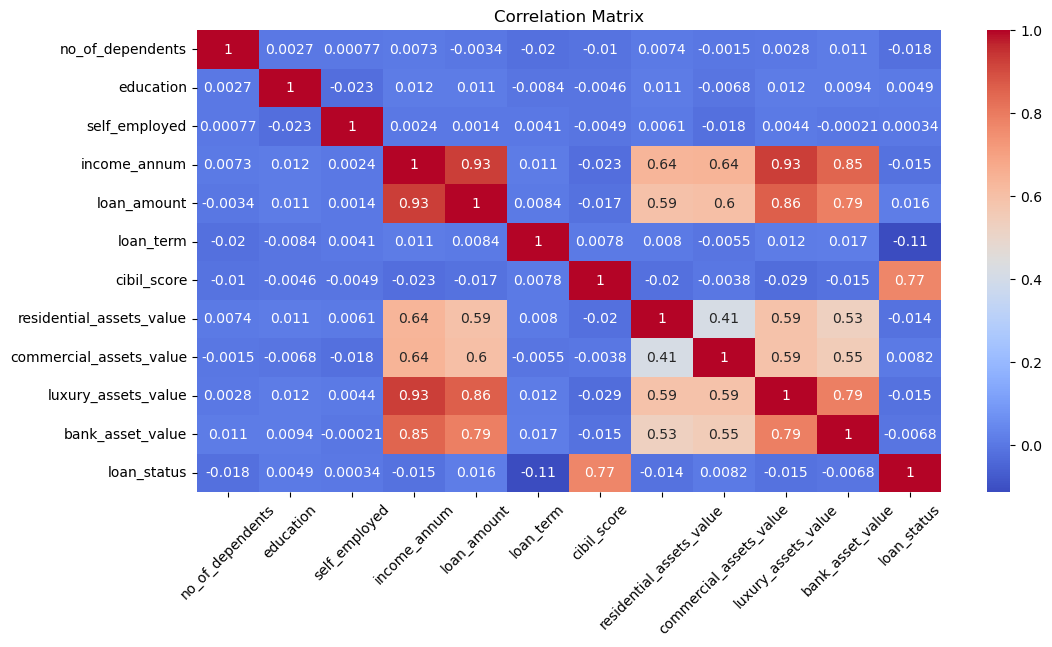

In [51]:
corr_matrix = loans.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

## Initial model testing

In [8]:
#loan_status
#1    2656
#0    1613
#1043

X = loans.drop("loan_status", axis=1)
y = loans["loan_status"]

# Split training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=0.3)

# Onehot
X_train_onehot = pd.get_dummies(X_train, columns=["no_of_dependents"])
X_test_onehot = pd.get_dummies(X_test, columns=["no_of_dependents"])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_onehot)
X_test_scaled = scaler.fit_transform(X_test_onehot)

# Balancing with smote
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_onehot, y_train)
X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Balancing by dropping randomly
indices_to_drop = np.where(y_train == 1)[0]
indices_to_keep = np.random.choice(indices_to_drop, size=len(indices_to_drop)-1043, replace=False)

X_train_drop = np.delete(X_train_onehot, indices_to_keep, axis=0)
X_train_scaled_drop = np.delete(X_train_scaled, indices_to_keep, axis=0)
y_train_drop = np.delete(y_train, indices_to_keep, axis=0)

# Comparing accuracies
accs_base = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "xgb":0}
accs_onehot = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "xgb":0}
accs_scaled = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "xgb":0}
accs_smote = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "xgb":0}
accs_drop = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "xgb":0}

In [9]:
# Base models
knn = KNeighborsClassifier(n_neighbors=7)
lr = LogisticRegression(random_state=1234)
dtc = DecisionTreeClassifier(random_state=1234)
rfc = RandomForestClassifier(random_state=1234)
svc = SVC(kernel="linear")
xgb = XGBClassifier(random_state=1234)

In [10]:
# Untreated data
accs_base["knn"] = cross_val_score(knn, X_train, y_train).mean()
accs_base["lr"] = cross_val_score(lr, X_train, y_train).mean()
accs_base["dtc"] = cross_val_score(dtc, X_train, y_train).mean()
accs_base["rfc"] = cross_val_score(rfc, X_train, y_train).mean()
#accs_base["svc"] = cross_val_score(svc, X_train, y_train).mean() # Needs scaling
accs_base["xgb"] = cross_val_score(xgb, X_train, y_train).mean()

In [11]:
# One-hot encoded data
accs_onehot["knn"] = cross_val_score(knn, X_train_onehot, y_train).mean()
accs_onehot["lr"] = cross_val_score(lr, X_train_onehot, y_train).mean()
accs_onehot["dtc"] = cross_val_score(dtc, X_train_onehot, y_train).mean()
accs_onehot["rfc"] = cross_val_score(rfc, X_train_onehot, y_train).mean()
#accs_onehot["svc"] = cross_val_score(svc, X_train_onehot, y_train).mean() # Needs scaling
accs_onehot["xgb"] = cross_val_score(xgb, X_train_onehot, y_train).mean()

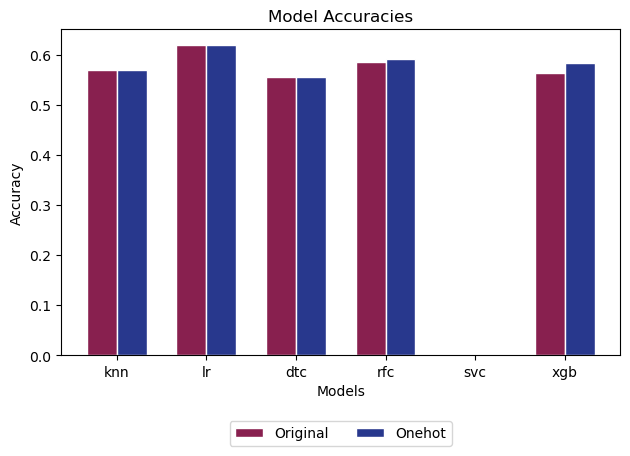

In [12]:
# One-hot encoding slightly improves some models so we use that moving forward
rp.plot_multi_bar_graph([accs_base, accs_onehot], ["Original", "Onehot"])

In [13]:
# Scaled data
accs_scaled["knn"] = cross_val_score(knn, X_train_scaled, y_train).mean()
accs_scaled["lr"] = cross_val_score(lr, X_train_scaled, y_train).mean()
accs_scaled["dtc"] = cross_val_score(dtc, X_train_scaled, y_train).mean()
accs_scaled["rfc"] = cross_val_score(rfc, X_train_scaled, y_train).mean()
accs_scaled["svc"] = cross_val_score(svc, X_train_scaled, y_train).mean() # Needs scaling
accs_scaled["xgb"] = cross_val_score(xgb, X_train_scaled, y_train).mean()

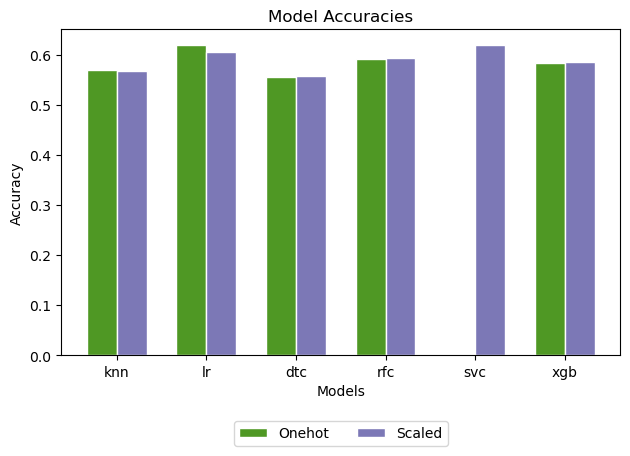

In [14]:
# Unscaled data performs slightly better in knn and lr so we us it with those models moving forward
rp.plot_multi_bar_graph([accs_onehot, accs_scaled], ["Onehot", "Scaled"])

In [15]:
# Balanced smote
accs_smote["knn"] = cross_val_score(knn, X_train_smote, y_train_smote).mean()
accs_smote["lr"] = cross_val_score(lr, X_train_smote, y_train_smote).mean()
accs_smote["dtc"] = cross_val_score(dtc, X_train_scaled_smote, y_train_smote).mean()
accs_smote["rfc"] = cross_val_score(rfc, X_train_scaled_smote, y_train_smote).mean()
accs_smote["svc"] = cross_val_score(svc, X_train_scaled_smote, y_train_smote).mean() # Needs scaling
accs_smote["xgb"] = cross_val_score(xgb, X_train_scaled_smote, y_train_smote).mean()

In [16]:
# Balanced drop
accs_drop["knn"] = cross_val_score(knn, X_train_drop, y_train_drop).mean()
accs_drop["lr"] = cross_val_score(lr, X_train_drop, y_train_drop).mean()
accs_drop["dtc"] = cross_val_score(dtc, X_train_scaled_drop, y_train_drop).mean()
accs_drop["rfc"] = cross_val_score(rfc, X_train_scaled_drop, y_train_drop).mean()
accs_drop["svc"] = cross_val_score(svc, X_train_scaled_drop, y_train_drop).mean() # Needs scaling
accs_drop["xgb"] = cross_val_score(xgb, X_train_scaled_drop, y_train_drop).mean()

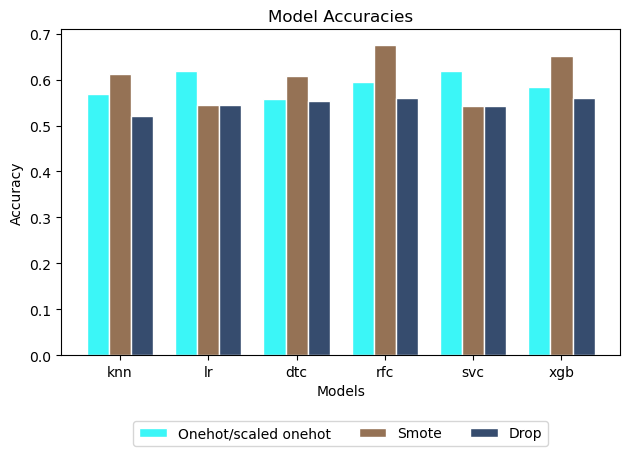

In [17]:
accs_prev_best = {"knn":accs_onehot["knn"], "lr":accs_onehot["lr"], "dtc":accs_scaled["dtc"], "rfc":accs_scaled["rfc"], "svc":accs_scaled["svc"], "xgb":accs_scaled["xgb"]}
rp.plot_multi_bar_graph([accs_prev_best, accs_smote, accs_drop], ["Onehot/scaled onehot", "Smote", "Drop"])

## Pre tuning evaluation

In [18]:
# effect of balancing on test performance
X_train_scaled_smote, y_train_smote
X_test_scaled, y_test

(array([[-0.99455037, -1.04226639, -1.71571041, ..., -0.48015367,
         -0.45035198,  2.36708529],
        [-0.99455037, -1.04226639,  1.38192402, ..., -0.48015367,
         -0.45035198, -0.42246048],
        [-0.99455037, -1.04226639, -0.78998058, ..., -0.48015367,
         -0.45035198, -0.42246048],
        ...,
        [-0.99455037,  0.95944762, -1.00361054, ..., -0.48015367,
         -0.45035198,  2.36708529],
        [ 1.00547949,  0.95944762,  1.34631903, ..., -0.48015367,
         -0.45035198,  2.36708529],
        [ 1.00547949,  0.95944762, -1.2528455 , ..., -0.48015367,
         -0.45035198, -0.42246048]]),
 3393    0
 2717    1
 3367    1
 1129    1
 2256    1
        ..
 4176    0
 2632    1
 2196    1
 151     1
 1102    0
 Name: loan_status, Length: 1281, dtype: int64)

In [19]:
# using best performing featureset for each model
# For simplicity, use scaled onehot encoded smote vs scaled onehot oncoded
accs_final = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "xgb":0}

knn.fit(X_train_scaled_smote, y_train_smote)
y_pred = knn.predict(X_test_scaled)
accs_final["knn"] = accuracy_score(y_test, y_pred)

lr.fit(X_train_scaled_smote, y_train_smote)
y_pred = lr.predict(X_test_scaled)
accs_final["lr"] = accuracy_score(y_test, y_pred)

dtc.fit(X_train_scaled_smote, y_train_smote)
y_pred = dtc.predict(X_test_scaled)
accs_final["dtc"] = accuracy_score(y_test, y_pred)

rfc.fit(X_train_scaled_smote, y_train_smote)
y_pred = rfc.predict(X_test_scaled)
accs_final["rfc"] = accuracy_score(y_test, y_pred)

svc.fit(X_train_scaled_smote, y_train_smote)
y_pred = svc.predict(X_test_scaled)
accs_final["svc"] = accuracy_score(y_test, y_pred)

xgb.fit(X_train_scaled_smote, y_train_smote)
y_pred = xgb.predict(X_test_scaled)
accs_final["xgb"] = accuracy_score(y_test, y_pred)

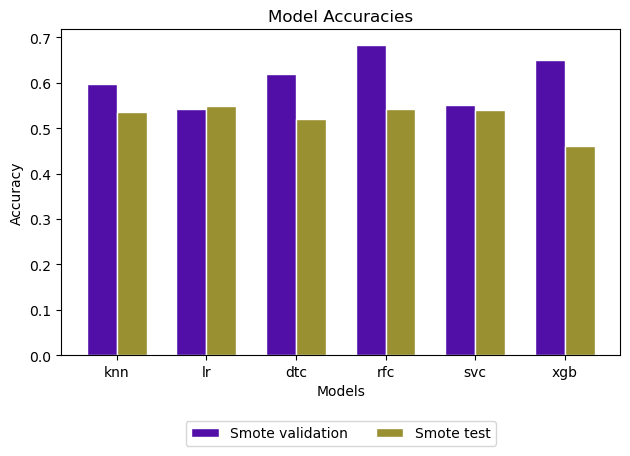

In [20]:
# Using smote seems to lead to overfitting
rp.plot_multi_bar_graph([accs_smote, accs_final], ["Smote validation", "Smote test"])

In [21]:
# using best performing featureset for each model
# For simplicity, use scaled onehot encoded smote vs scaled onehot oncoded
accs_final_no_smote = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "xgb":0}

knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
accs_final_no_smote["knn"] = accuracy_score(y_test, y_pred)

lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
accs_final_no_smote["lr"] = accuracy_score(y_test, y_pred)

dtc.fit(X_train_scaled, y_train)
y_pred = dtc.predict(X_test_scaled)
accs_final_no_smote["dtc"] = accuracy_score(y_test, y_pred)

rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)
accs_final_no_smote["rfc"] = accuracy_score(y_test, y_pred)

svc.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)
accs_final_no_smote["svc"] = accuracy_score(y_test, y_pred)

xgb.fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)
accs_final_no_smote["xgb"] = accuracy_score(y_test, y_pred)

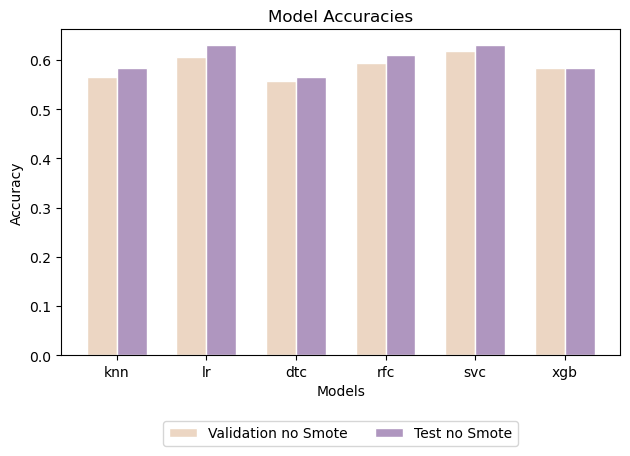

In [22]:
# ...
rp.plot_multi_bar_graph([accs_scaled, accs_final_no_smote], ["Validation no Smote", "Test no Smote"])

## Feature selection
#### Using the best performing featureset for each model (X_train, X_train_smote, X_train_drop)

In [23]:
knn_sfs = SFS(
    knn,
    k_features=(1, X_train_smote.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
knn_sfs.fit(X_train_smote, y_train_smote)

SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=7),
                          k_features=(1, 15), n_jobs=-1, scoring='accuracy')

In [18]:
lr_sfs = SFS(
    lr,
    k_features=(1, X_train_scaled.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
lr_sfs.fit(X_train_scaled, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(random_state=1234),
                          k_features=(1, 15), n_jobs=-1, scoring='accuracy')

In [19]:
dtc_sfs = SFS(
    dtc,
    k_features=(1, X_train.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
dtc_sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(random_state=1234),
                          k_features=(1, 10), n_jobs=-1, scoring='accuracy')

In [20]:
rfc_sfs = SFS(
    rfc,
    k_features=(1, X_train_scaled.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
rfc_sfs.fit(X_train_scaled, y_train)

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=1234),
                          k_features=(1, 15), n_jobs=-1, scoring='accuracy')

In [21]:
svc_sfs = SFS(
    svc,
    k_features=(1, X_train_scaled.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
svc_sfs.fit(X_train_scaled, y_train)

SequentialFeatureSelector(estimator=SVC(kernel='linear'), k_features=(1, 15),
                          n_jobs=-1, scoring='accuracy')

In [22]:
#This is super slow

xgb_sfs = SFS(
    xgb,
    k_features=(1, X_train_scaled.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1
)
xgb_sfs.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.6s finished
Features: 1/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    5.0s finished
Features: 2/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    5.1s finished
Features: 3/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.3s finished
Features: 4/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    5.4s finished
Features: 5/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.3s finished
Features: 6/15[Parallel(n_jobs=-1)]: Using backe

SequentialFeatureSelector(estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=100, n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=1234, ...),
                          k_features=(1, 15), n_jobs=-1, scoring='accuracy',
                          verbose=1)

In [23]:
plot_sfs(knn_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("knn forward selection")
plt.legend(["Standard deviation", "Mean performance"])

NameError: name 'knn_sfs' is not defined

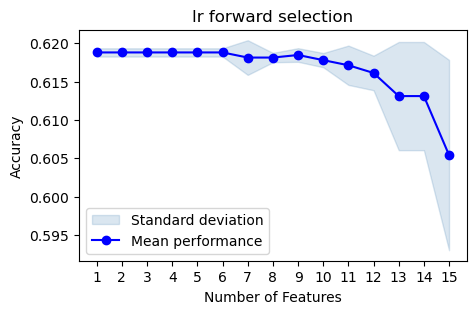

In [24]:
plot_sfs(lr_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("lr forward selection")
plt.legend(["Standard deviation", "Mean performance"])

In [ ]:
plot_sfs(dtc_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("dtc forward selection")
plt.legend(["Standard deviation", "Mean performance"])

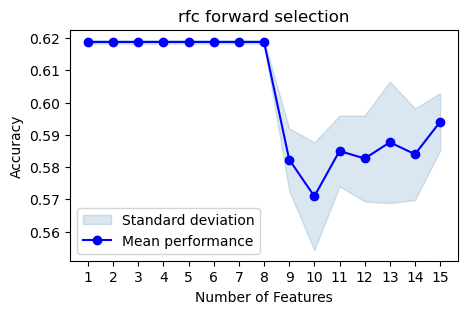

In [25]:
plot_sfs(rfc_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("rfc forward selection")
plt.legend(["Standard deviation", "Mean performance"])

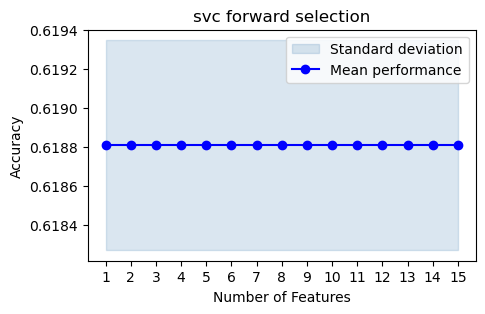

In [26]:
plot_sfs(svc_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("svc forward selection")
plt.legend(["Standard deviation", "Mean performance"])

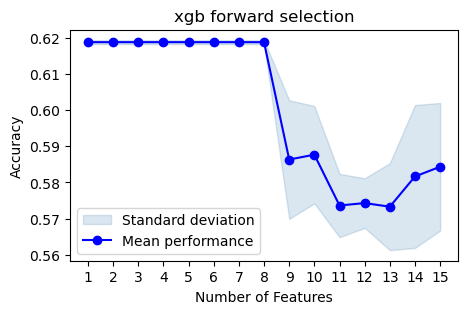

In [27]:
plot_sfs(xgb_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("xgb forward selection")
plt.legend(["Standard deviation", "Mean performance"])

## Hyperparameter optimization

In [28]:
# lr_sfs
lr_sfs_indexes = [int(index) for index in lr_sfs.get_metric_dict()[6]["feature_names"]]
X_train_scaled_lr_sfs = X_train_scaled[:, lr_sfs_indexes]
X_test_scaled_lr_sfs = X_test_scaled[:, lr_sfs_indexes]


# rfc_sfs
rfc_sfs_indexes = [int(index) for index in rfc_sfs.get_metric_dict()[8]["feature_names"]]
X_train_scaled_rfc_sfs = X_train_scaled[:, rfc_sfs_indexes]
X_test_scaled_rfc_sfs = X_test_scaled[:, rfc_sfs_indexes]


# xgb_sfs
xgb_sfs_indexes = [int(index) for index in xgb_sfs.get_metric_dict()[8]["feature_names"]]
X_train_scaled_xgb_sfs = X_train_scaled[:, xgb_sfs_indexes]
X_test_scaled_xgb_sfs = X_test_scaled[:, xgb_sfs_indexes]

In [30]:
param_grid = {
    'n_estimators': [175, 180, 185, 190],
    'max_depth': [None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2'],
    'criterion': ['gini'],
    'random_state': [1234],
    'class_weight':[{0: 1, 1: 9.0}]
#    'n_estimators': [100, 200, 300],              # Number of trees in the forest
#    'max_features': ['sqrt', 'log2'],   # Number of features to consider for the best split
#    'max_depth': [None, 10, 20, 30],            # Maximum depth of the tree
#    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
#    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required to be at a leaf node
#    'bootstrap': [True, False],                 # Whether bootstrap samples are used when building trees
#    'criterion': ['gini', 'entropy'] 
}

# Create a GridSearchCV object and fit it to your data
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring="accuracy",refit=True, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled_rfc_sfs, y_train)

# Retrieve the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters:  {'class_weight': {0: 1, 1: 9.0}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 175, 'random_state': 1234}
Best Score:  0.618808647473712


## Regularization testing

## Final model evaluation

#### RFC

In [31]:
final_rf = RandomForestClassifier(n_estimators=185, criterion="gini", max_depth=None, max_features="log2", min_samples_leaf=1, min_samples_split=3, random_state=1234, class_weight={0: 1, 1: 9.0})
final_rf.fit(X_train_scaled_rfc_sfs, y_train)
y_pred_final_rf = final_rf.predict(X_test_scaled_rfc_sfs)

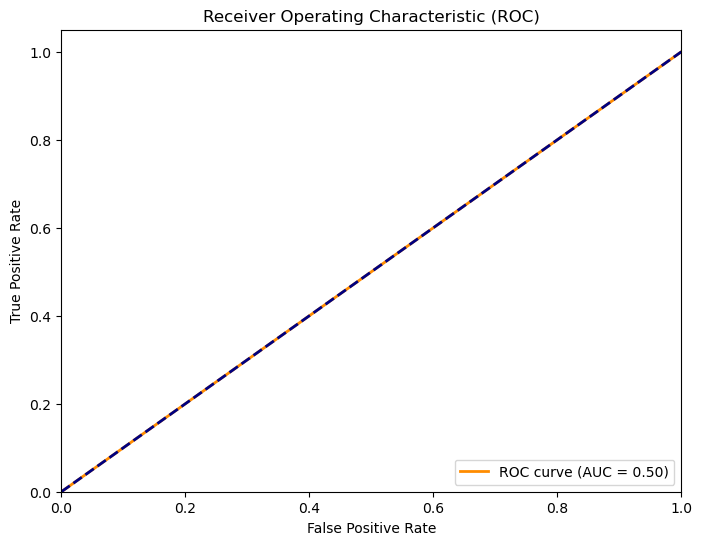

In [32]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_final_rf)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [33]:
accuracy_score(y_test, y_pred_final_rf)

0.629976580796253

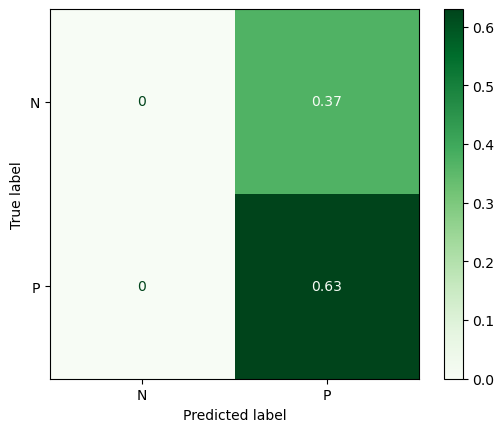

In [45]:
cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final_rf, cmap="Greens", display_labels=["N", "P"], normalize="all")

#### lr

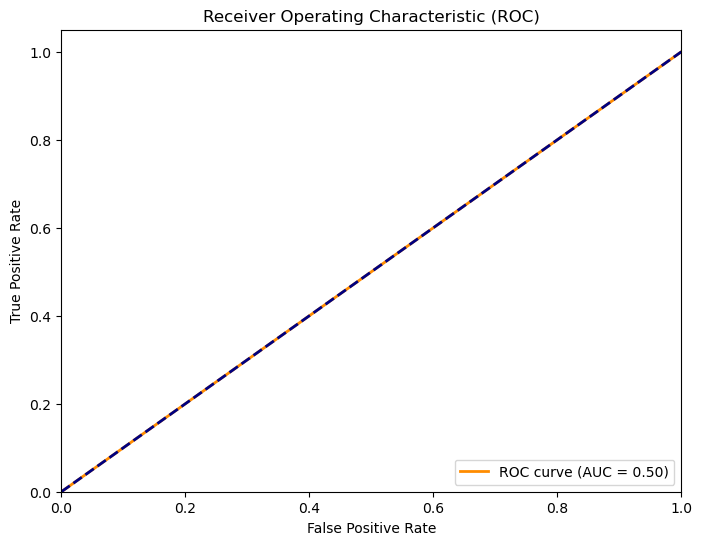

In [39]:
#final_lr = LogisticRegression()
lr.fit(X_train_scaled_lr_sfs, y_train)
y_pred_final_lr = lr.predict(X_test_scaled_lr_sfs)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [40]:
accuracy_score(y_pred, y_test)

0.629976580796253

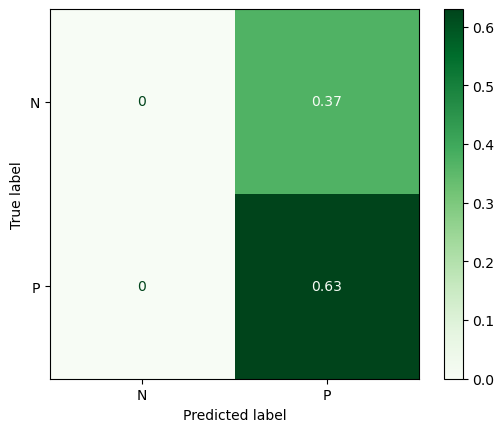

In [41]:
cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Greens", display_labels=["N", "P"], normalize="all")

#### xgb

In [90]:
params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3),
    'depth': optuna.distributions.FloatDistribution(4, 10),
    'n_estimators': optuna.distributions.FloatDistribution(50, 500),
    # Add other hyperparameters with appropriate distributions
}

optuna_search = OptunaSearchCV(
    estimator=XGBClassifier(n_jobs=-1),  # Your classifier here
    param_distributions=params,  # Define parameter space
    scoring="accuracy",
    n_trials=100,  # Number of trials (adjust as needed)
    cv=5,  # Number of cross-validation folds
    n_jobs=1,  # Number of CPU cores to use (-1 means all available)
    verbose=0  # Verbosity level (1 for progress updates)
)

/tmp/ipykernel_1649/547085014.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(


In [91]:
xgb_optuna = optuna_search.fit(X_train_scaled_xgb_sfs, y_train)  # Fit on your data

[I 2023-10-05 21:43:33,373] A new study created in memory with name: no-name-a4bd7bd1-1d47-4ec5-b04e-3c9001c30ebf
/opt/software/lib/python3.10/site-packages/optuna/integration/sklearn.py:355: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/opt/software/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2023-10-05 21:43:33,388] Trial 0 failed with parameters: {'learning_rate': 0.15540769125709628, 'depth': 9.933383729335395, 'n_estimators': 301.1896494780879} because of the following error: The value nan is not acceptable.
[W 2023-10-05 21:43:33,389] Trial 0 failed with value nan.
/opt/software/lib/python3.10/site-packages/optuna/integration/sklearn.py:355: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/opt/software/lib/python3.10/site-packages/numpy/lib/n

In [89]:
xgb_optuna.best_params_

ValueError: No trials are completed yet.

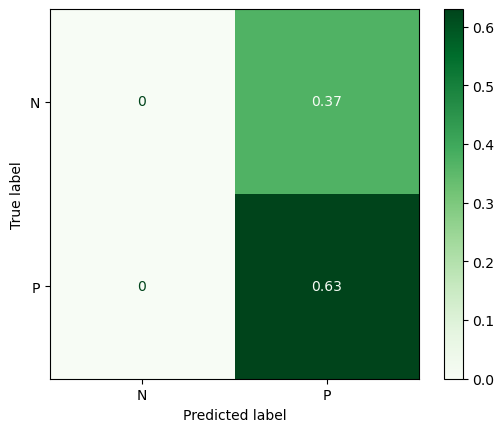

In [59]:
cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Greens", display_labels=["N", "P"], normalize="all")

(2988, 8)